In [5]:
import numpy as np # linear algebra
import torch.nn as nn
import torch

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,inputs,targets):
        self.inputs = inputs
        self.targets = targets
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,item):
        image = self.inputs[item]
        targets = self.targets[item]
    
        return {
            "X": torch.tensor(image, dtype=torch.float),
            "Y": torch.tensor(targets, dtype=torch.float),
        }

In [7]:
def train(model,train_loader,device,optimizer):
    model.train()
    running_train_loss = 0.0
    for data in train_loader:
        inputs = data['X'].view(-1,1)
        targets = data['Y'].view(-1,1)

        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss +=loss.item()
        
    train_loss_value = running_train_loss/len(train_loader)
    print(f'train loss is {train_loss_value}')
    
def eval(model,valid_loader,device,optimizer):
    model.eval()
    final_inputs = []
    final_targets = []
    final_outputs = []
    running_val_loss = 0.0
    with torch.no_grad():
        for data in valid_loader:
            inputs = data['X'].view(-1,1)
            targets = data['Y'].view(-1,1)
            
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            output = model(inputs)
            running_val_loss += nn.MSELoss()(output, targets)
            
            targets = (targets.detach().cpu().numpy()).tolist()
            output = (output.detach().cpu().numpy()).tolist()
            
            final_inputs.extend((inputs.detach().cpu().numpy()).tolist())
            final_outputs.extend(output)
            final_targets.extend(targets)
            
        val_loss = running_val_loss/len(valid_loader)    
        print(f'valid BCE loss is {val_loss}')
        
    return final_inputs,final_outputs,final_targets      

In [8]:
class get_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
        nn.Linear(1,64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64,8),
        nn.BatchNorm1d(8),
        nn.ReLU(),
        )
        self.layer_2 = nn.Sequential(
        nn.Linear(8,4),
        nn.BatchNorm1d(4),
        nn.ReLU(),
        nn.Linear(4,1),
        )
    def forward(self, x):
        x = self.layer_1(x)
#         print(x.shape)
        x = self.layer_2(x)
        return x

In [9]:
model = get_model()
# model.to("cpu")

In [10]:
# model(torch.ones((4,1)))

In [33]:
data = np.arange(-5,5,0.05)
targets = data**2

In [40]:
from sklearn.model_selection import train_test_split
train_inputs, valid_inputs, train_targets, valid_targets = train_test_split(
    data, targets, test_size=0.1, random_state=42)

In [41]:
train_dataset = Dataset(train_inputs,train_targets)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True) 

valid_dataset = Dataset(valid_inputs,valid_targets)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=32,shuffle=False,pin_memory=True) 

optimizer = torch.optim.SGD(model.parameters(),lr=5e-5)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=5,verbose=True)

epochs = 20
device = "cpu"
for epoch in range(epochs):
    print(f'==================== Epoch -- {epoch} ====================')
    train(model=model,train_loader=train_loader,device=device,optimizer=optimizer)

    final_inputs,final_outputs,final_targets  = eval(model=model,valid_loader=valid_loader,device=device,optimizer=optimizer)

#     RMSE = np.sqrt(metrics.mean_squared_error(final_targets,final_outputs))
#             scheduler.step(RMSE)

#     print(f'valid RMSE={RMSE}')
# torch.save(model.state_dict(),'model-epoch'+str(fold)+'.pth')
# scores.append(RMSE)

==================== Epoch -- 0 ====================
train loss is 587.3553263346354
valid BCE loss is 603.60986328125
==================== Epoch -- 1 ====================
train loss is 569.5971476236979
valid BCE loss is 649.109130859375
==================== Epoch -- 2 ====================
train loss is 493.7963511149089
valid BCE loss is 548.07373046875
==================== Epoch -- 3 ====================
train loss is 465.3211161295573
valid BCE loss is 506.13397216796875
==================== Epoch -- 4 ====================
train loss is 435.2259267171224
valid BCE loss is 476.4869689941406
==================== Epoch -- 5 ====================
train loss is 420.73944600423175
valid BCE loss is 469.6767578125
==================== Epoch -- 6 ====================
train loss is 391.5778096516927
valid BCE loss is 437.4220275878906
==================== Epoch -- 7 ====================
train loss is 356.37611389160156
valid BCE loss is 398.7967224121094
==================== Epoch -- 8 =====

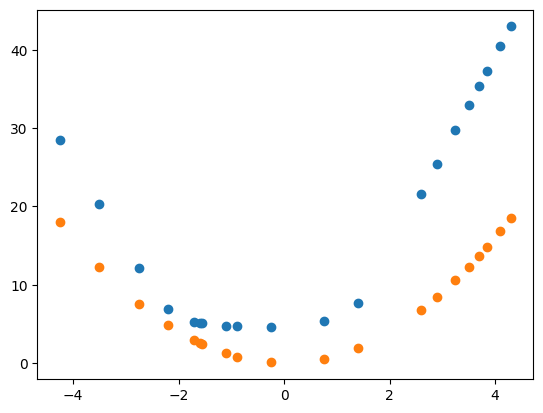

In [42]:
import matplotlib.pyplot as plt

valid_dataset = Dataset(valid_inputs,valid_targets)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=False,pin_memory=True)

plt.scatter(np.array(final_inputs).flatten(),np.array(final_outputs).flatten())
plt.scatter(np.array(final_inputs).flatten(),np.array(final_targets).flatten())

##  Testing out of Bounds 

valid BCE loss is 141.00051879882812


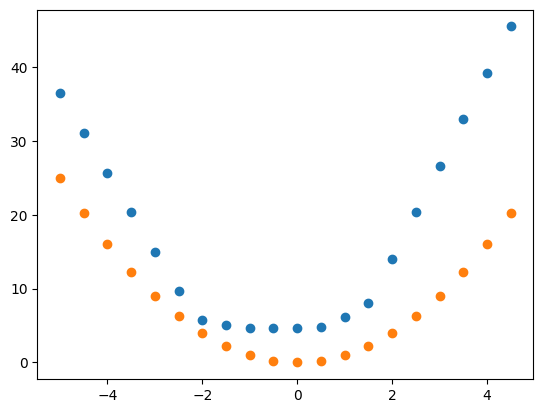

In [45]:
import matplotlib.pyplot as plt

data = np.arange(-5,5,0.5)
targets = data**2

valid_dataset = Dataset(data,targets)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=False,pin_memory=True) 

final_inputs,final_outputs,final_targets  = eval(model=model,valid_loader=valid_loader,device=device,optimizer=optimizer)
plt.scatter(np.array(final_inputs).flatten(),np.array(final_outputs).flatten())
plt.scatter(np.array(final_inputs).flatten(),np.array(final_targets).flatten())